In [89]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization
from quantum_electron.utils import xy2r, r2xy
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me
from alive_progress import alive_bar

In this notebook we study potentials that have a mirror symmetry along one axis. A relevant example is a micro-channel with an electrode at the bottom of the channel. This electrode can generate a parabolic confinement along the channel axis, and electrons are confined by the surrounding ground plane. In an experimental device such channels are usually long, and simulating the full length of the channel is untractable. In addition, trying to cap the ends of the channel will result in electron configurations that don't represent the experiment. Therefore, periodic boundary conditions are implemented in this module.

In the example below, we'll create a sample potential for a micro-channel running along the $x$-direction. We then impose the periodic boundary conditions and look at the resulting electron row formation and mode frequencies.

# Create the potential

In [120]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-4, 4, 301)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_channel = - Y ** 2 / micron ** 2

channel_width = 3e-6
parabolic_channel[np.abs(Y) > channel_width / 2] = - (channel_width/2) ** 2 / micron ** 2

# also add the guard ring
gnd_plane = np.ones(X.shape)
gnd_plane[np.abs(Y) < channel_width / 2] = 0 

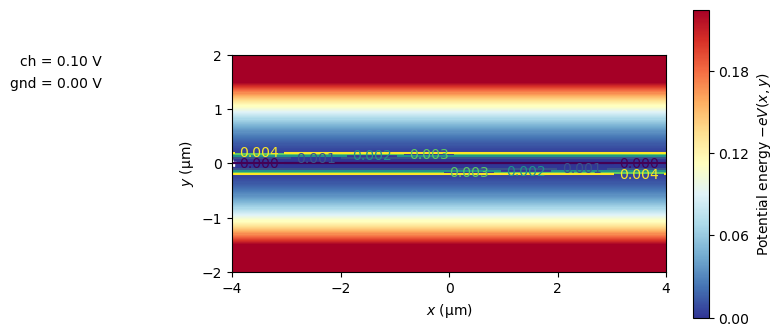

In [121]:
potential_dict = {"ch" : parabolic_channel.T, 
                  "gnd" : gnd_plane.T, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"ch" : 0.1, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(8, 4))

# Adding electrons

When adding electrons to this potential the periodic boundary conditions ensure that electrons that leave on the right, appear automatically on the left of the simulation domain. Similarly, when `periodic_boundaries = ['y']` electrons that leave towards the top of the simulation domain automatically appear on the bottom. 

In the ideal case of periodic boundaries, electrons would see their own image multiple times and this gives rise to a choice: where do we cut off the coulomb interactions? In this code we choose that each electron only sees every other electron in the simulation box exactly once. If the electron is close to the right border, the interaction with electrons close to the left border is taken with the periodic boundary in mind. That is, we take the minimum distance to each electron, without double counting. 

This choice of approximation is typically acceptable for microchannels which are long enough. 

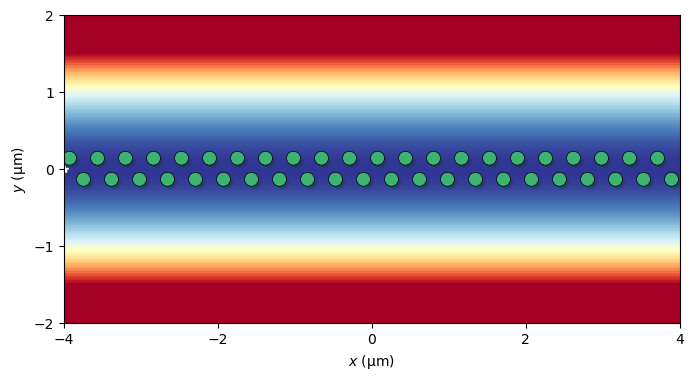

In [122]:
n_electrons = 45

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.periodic_boundaries = ['x']
fm.remove_unbound_electrons = False

# Create a rectangular initial condition
init_x = np.tile(np.linspace(-3, 3, n_electrons // 2), 2) * micron
init_y = np.repeat(np.array([-.2, .2]), n_electrons// 2) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

fm.plot_potential_energy(ax=ax, dxdy=(8, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)
# plt.plot(initial_condition[::2]/micron, initial_condition[1::2]/micron, '.r')

We see the emergence of the electron rows in this case, which are determined by the center pin voltage and the number of electrons in the simulation domain.

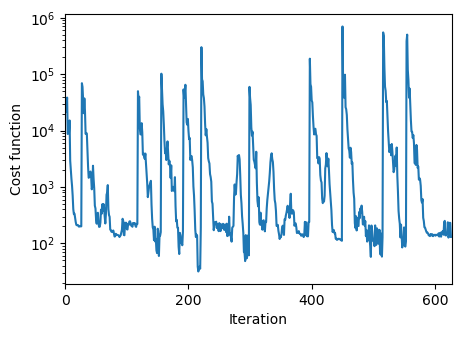

In [123]:
fm.plot_convergence()

# Sweep voltages

The row structure is known to depend on the confinement, which is tunable with the center pin voltage. One way to show this is by sweeping the center pin voltage and binning the electron coordinates along the $y$-axis. Note that for small confinements the electrons tend to escape the channel. We may choose to remove these electrons with the option `remove_unbound_electrons = True`. See the example below

In [149]:
n_electrons = 100
n_ybins = 201

ch_voltages = np.linspace(3.00, 0.05, 101)
electron_histogram = np.zeros((len(ch_voltages), n_ybins-1))

with alive_bar(len(ch_voltages), force_tty=True) as bar:
    for k, Vch in enumerate(ch_voltages):

        voltages = {"ch" : Vch, 
                    "gnd" : 0}

        fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
        fm.periodic_boundaries = ['x']
        fm.remove_unbound_electrons = False

        if k == 0:
            # Create a rectangular initial condition
            init_x = np.tile(np.linspace(-3, 3, n_electrons // 2), 2) * micron
            init_y = np.repeat(np.array([-.2, .2]), n_electrons// 2) * micron
            initial_condition = xy2r(init_x, init_y)
        else: 
            # Use the results of the previous iterations for the current time step.
            initial_condition = res['x']
        
        # Feed this into the model
        res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

        final_x, final_y = r2xy(res['x'])
        hist_yfreq, hist_ybins = np.histogram(final_y, bins=0.5 * np.linspace(-channel_width/2, channel_width/2., n_ybins))
        
        electron_histogram[k, :] = hist_yfreq
        bar()
        
ybin_centers = 0.5 * (hist_ybins[1:] + hist_ybins[:-1])


|████████████████████████████████████████| 101/101 [100%] in 3:24.6 (0.49/s)                                            


(0.05, 1.0)

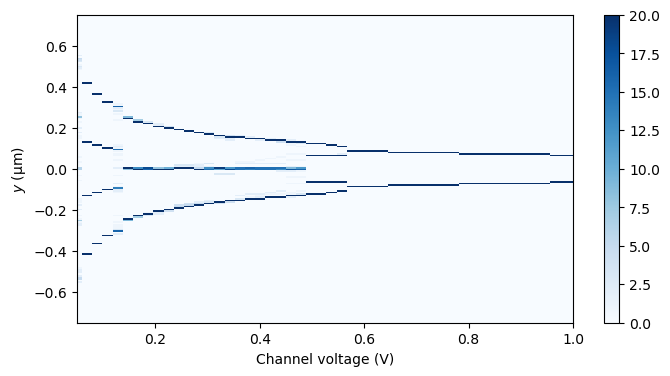

In [126]:
plt.figure(figsize=(8., 4.))
plt.pcolormesh(ch_voltages, ybin_centers / micron, electron_histogram.T, vmax=20, cmap=plt.cm.Blues)
plt.colorbar()

plt.xlabel("Channel voltage (V)")
plt.ylabel(fr"$y$ ({chr(956)}m)")
plt.xlim(0.05, 1.0)

The emergence of electron rows is studied extensively in the literature, and the transition from $n=2$ rows at high voltage to $n = 2, 4, 3, ...$ is known as well in these papers: 
- https://link.springer.com/article/10.1007/s10909-015-1344-4 
- https://journals.aps.org/prb/abstract/10.1103/PhysRevB.69.045324 

Great success!

# Eigenmodes

The eigenmodes of electrons in a microchannel and their interaction with a microwave resonator has been studied in this work: 
- https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.011031

Here we look to reproduce these eigenmodes. Let us first try to get a sense of the frequency scale in this problem, which is set by the trap curvature:

In [148]:
print("Trap curvature for electrons is", 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['ch'] / micron ** 2 / me), "GHz")

Trap curvature for electrons is 21.107209982922 GHz


/Users/gerwinkoolstra/opt/anaconda3/envs/eonhe/lib/python3.10/site-packages/quantum_electron/eom_solver.py:260: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(EVals) / (2 * np.pi), EVecs


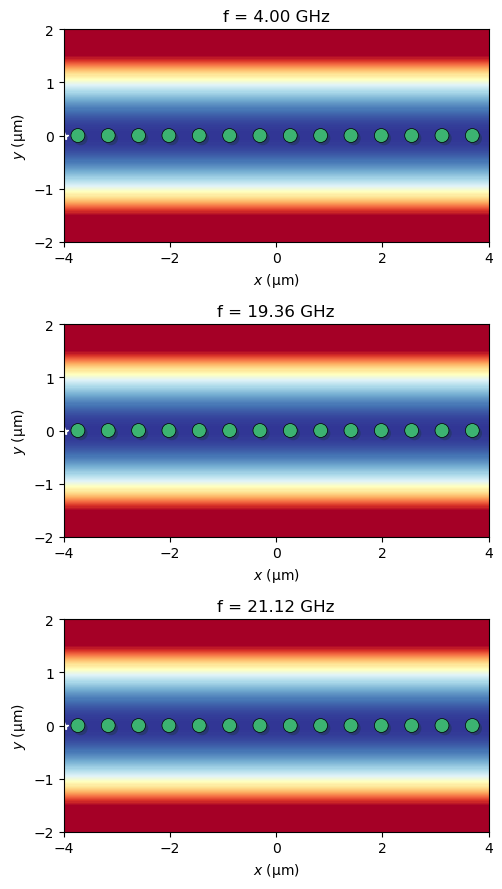

In [139]:
n_electrons = 15
n_plots = 3

fig, ax = plt.subplots(n_plots, 1, figsize=(6, 3*n_plots))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.periodic_boundaries = ['x']
fm.remove_unbound_electrons = False
fm.set_rf_interpolator(rf_electrode_labels=['ch'])

# Create a rectangular initial condition
init_x = np.tile(np.linspace(-3, 3, n_electrons // 2), 2) * micron
init_y = np.repeat(np.array([-.2, .2]), n_electrons// 2) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(8, 4), print_voltages=False, plot_contours=False)
    # fm.plot_electron_positions(res, ax=ax[n])

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'])
    efreqs, evecs = fm.solve_eom(K, M)

    # fm.plot_eigenvector(res['x'], evecs[:, n])

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    
fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'])

In [140]:
fm.show_animation(anim)

Here we see an issue that the eigenmodes don't see the neighbors from the periodic boundary conditions yet. This still needs to be implemented!